In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
X, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
X = X

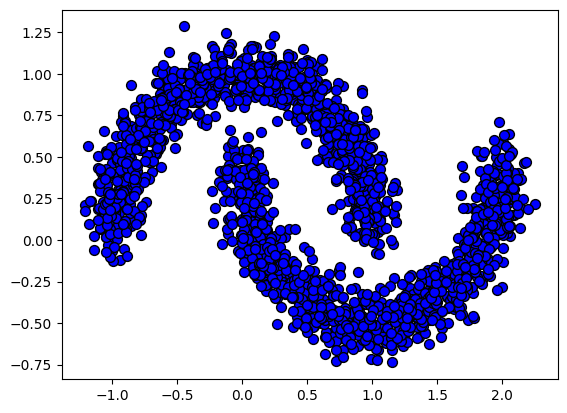

In [3]:
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50)
plt.show()

In [4]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [5]:
class Denoiser(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Denoiser, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        t = torch.unsqueeze(t, 1)
        x_for = torch.cat((x, t), dim=1)
        x_for = torch.relu(self.fc1(x_for))
        x_for = torch.relu(self.fc2(x_for))
        x_for = torch.relu(self.fc3(x_for))
        x_for = torch.relu(self.fc4(x_for))
        return self.fc5(x_for)

model = Denoiser(2, 2, 64).to(device)

In [20]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02, n_skip = 0):
        self.model = model
        self.timesteps = timesteps-n_skip
        self.reversed_time_steps = np.arange(self.timesteps)[::-1]
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.alphas = self.alphas[n_skip:]
        self.betas = self.betas[n_skip:]
        self.alphas_cumprod = self.alphas_cumprod[n_skip:]
        print(self.alphas_cumprod)

    def sample_sde(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                eps = self.model(x, t_tensor)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
        return x

    def sample_ode(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                eps = self.model(x, t_tensor)
                score = -eps/torch.sqrt(1.0 - self.alphas_cumprod[t])

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]
                xip = (2-torch.sqrt(1-beta_t))*x+1/2*beta_t*score
                x = xip# + torch.sqrt(beta_t)*noise
        return x

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def train(self, data, epochs=1000, batch_size=64, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
        losses = []
        mean_loss = 0
        i = 0

        for epoch in range(epochs):
            
            for batch in dataloader:
                optimizer.zero_grad()
                t = torch.randint(0, self.timesteps, (batch.size(0),), device=batch.device).long()
                noise = torch.randn_like(batch, dtype=torch.float32)
                noisy_data = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1) * noise
                predicted_noise = self.model(noisy_data, t)
                loss = criterion(predicted_noise, noise)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                optimizer.step()

            if epoch % 100 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
        return losses
    
ddpm = DDPM(model, timesteps=80, beta_start = 0.001, beta_end = 0.2)

tensor([9.9900e-01, 9.9548e-01, 9.8947e-01, 9.8101e-01, 9.7014e-01, 9.5695e-01,
        9.4153e-01, 9.2399e-01, 9.0444e-01, 8.8304e-01, 8.5991e-01, 8.3522e-01,
        8.0914e-01, 7.8183e-01, 7.5348e-01, 7.2426e-01, 6.9434e-01, 6.6391e-01,
        6.3315e-01, 6.0221e-01, 5.7127e-01, 5.4048e-01, 5.0999e-01, 4.7993e-01,
        4.5043e-01, 4.2162e-01, 3.9358e-01, 3.6642e-01, 3.4021e-01, 3.1502e-01,
        2.9090e-01, 2.6789e-01, 2.4603e-01, 2.2533e-01, 2.0581e-01, 1.8746e-01,
        1.7027e-01, 1.5423e-01, 1.3931e-01, 1.2549e-01, 1.1272e-01, 1.0096e-01,
        9.0181e-02, 8.0323e-02, 7.1340e-02, 6.3182e-02, 5.5797e-02, 4.9136e-02,
        4.3145e-02, 3.7777e-02, 3.2981e-02, 2.8711e-02, 2.4922e-02, 2.1569e-02,
        1.8614e-02, 1.6016e-02, 1.3741e-02, 1.1754e-02, 1.0025e-02, 8.5253e-03,
        7.2283e-03, 6.1104e-03, 5.1499e-03, 4.3275e-03, 3.6255e-03, 3.0283e-03,
        2.5218e-03, 2.0937e-03, 1.7329e-03, 1.4300e-03, 1.1764e-03, 9.6485e-04,
        7.8889e-04, 6.4304e-04, 5.2253e-

In [21]:
losses = ddpm.train(data, epochs=10000, batch_size=64, lr=5e-5)

Epoch 0, Loss: 0.204650211147964
Epoch 100, Loss: 0.20982116931816563
Epoch 200, Loss: 0.2102313098893501
Epoch 300, Loss: 0.20804659879999235
Epoch 400, Loss: 0.2092730551410932
Epoch 500, Loss: 0.20811139385565183
Epoch 600, Loss: 0.20719516747514719
Epoch 700, Loss: 0.2079499538661912
Epoch 800, Loss: 0.2090686203230871
Epoch 900, Loss: 0.20829327027779074
Epoch 1000, Loss: 0.20936614869977346
Epoch 1100, Loss: 0.2080254909954965
Epoch 1200, Loss: 0.2085004395490978
Epoch 1300, Loss: 0.20737749004387296
Epoch 1400, Loss: 0.20707509746076538
Epoch 1500, Loss: 0.20665111473645084
Epoch 1600, Loss: 0.20839138691197148
Epoch 1700, Loss: 0.20750299249659293
Epoch 1800, Loss: 0.20822004406480119
Epoch 1900, Loss: 0.2066701633599587
Epoch 2000, Loss: 0.2092663364519831
Epoch 2100, Loss: 0.20836854521825443
Epoch 2200, Loss: 0.20717300756368787
Epoch 2300, Loss: 0.20711909368284978
Epoch 2400, Loss: 0.2074519700743258
Epoch 2500, Loss: 0.20778599757701158
Epoch 2600, Loss: 0.207224110288079

KeyboardInterrupt: 

In [25]:
ddpm.store("models/simplemoons")

In [9]:
ddpm.load("models/simplemoons")

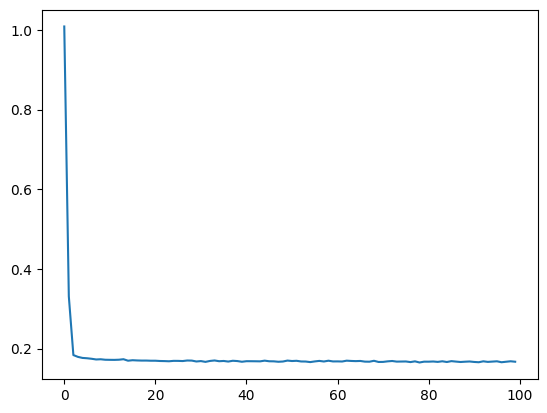

In [10]:
plt.plot(losses)
plt.show()

In [23]:
new_samples = ddpm.sample_ode(num_samples=2000).cpu().detach().numpy()

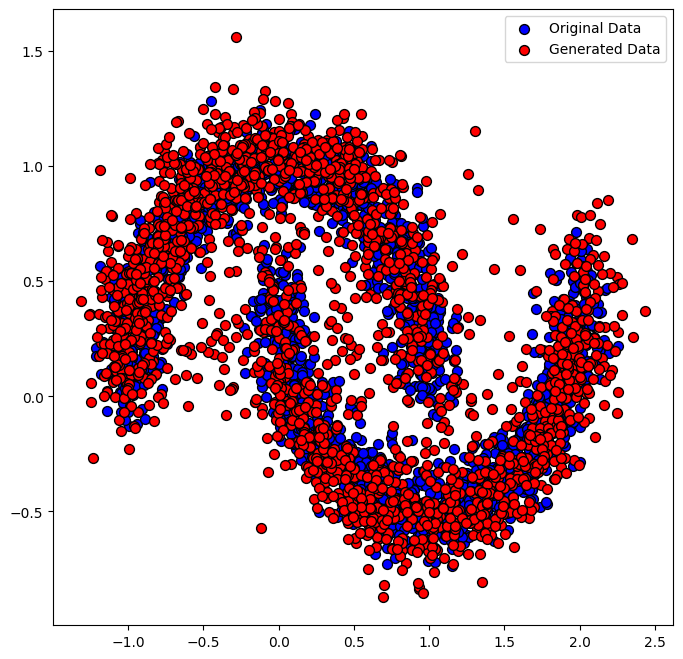

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()